In [1]:
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
ABPRED_DIR = Path().cwd().parent
DATA = ABPRED_DIR / "data"

#dataframe final
df_final = pd.read_csv(DATA/"DF_mutated_features300.csv",index_col=0)
# Quitar modelos por homologia deltraining set
#df_final= df_final.loc[~df_final.index.str.startswith("HM")]

col_names = df_final.columns
row_names = df_final.index

In [3]:
#Eliminar columnas con varianza 0 (por defecto) 
sel = VarianceThreshold(threshold=0.1).fit(df_final)
col_drops = sel.get_support()

#Sacar de la lista de column_indices
col_names_drop =np.asarray(col_names)[col_drops]
df_final_f1 = pd.DataFrame(sel.transform(df_final),columns=col_names_drop,index=row_names)

In [4]:
index_ddg8 = (df_final_f1['ddG(kcal/mol)']==8)
df_final_f1 = df_final_f1.loc[-index_ddg8]

#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final_f1['ddG(kcal/mol)'] <= -4)
df_ddg_4_2test = df_final_f1.loc[index_ddg_4]
df_final_f1 = df_final_f1.loc[-index_ddg_4]

In [32]:
#test drop samples with ddg 8 


In [5]:
X, y = df_final_f1.iloc[:,:-1],df_final_f1.iloc[:,-1]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=123)
                                                    

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


max_depth=7 ,  min_samples_leaf=1, min_samples_split=2,

In [7]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [25,30,40],
    'max_features': ["log2","sqrt"],
    'max_leaf_nodes':[20,30],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2,5,10],
    'n_estimators': [50,100],
    'random_state':[1],
    }

# Create a based model
rf = RandomForestRegressor(n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 10, scoring='neg_mean_squared_error',n_jobs = -1, verbose = 1)

In [8]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.1min finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [25, 30, 40], 'max_features': ['log2', 'sqrt'], 'max_leaf_nodes': [20, 30], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 5, 10], 'n_estimators': [50, 100], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [9]:
f = open("rf_models300F_results.txt","a")
print(grid_search.best_estimator_)
f.write('\n'+str(grid_search.best_estimator_))
print('\nBest GridSearchCV Score : ' + str(-grid_search.best_score_))

model = grid_search.best_estimator_

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print("OOB Score : " + str(model.oob_score_)) # yg diitung r2 score
print('Train MSE : ' + str(mean_squared_error(y_train, y_pred_train)))
print('Train MAE : ' + str(mean_absolute_error(y_train, y_pred_train)))
print('Train R^2 : ' + str(r2_score(y_train, y_pred_train)))

print('Test R^2 : ' + str(r2_score(y_test, y_pred_test)))
print('Test MSE : ' + str(mean_squared_error(y_test, y_pred_test)))
print('Test MAE : ' + str(mean_absolute_error(y_test, y_pred_test)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)))
print("pearson corr:\n",np.corrcoef(y_pred_test,y_test)[0][1])

f.write('\nTrain MSE : ' + str(mean_squared_error(y_train, y_pred_train)))
f.write('\nTrain MAE : ' + str(mean_absolute_error(y_train, y_pred_train)))
f.write('\nTrain R^2 : ' + str(r2_score(y_train, y_pred_train)))
f.write('\nTest R^2 : ' + str(r2_score(y_test, y_pred_test)))
f.write('\nTest MSE : ' + str(mean_squared_error(y_test, y_pred_test)))
f.write('\nTest MAE : ' + str(mean_absolute_error(y_test, y_pred_test)))

f.write("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)))
f.write("\npearson corr:\n"+str(np.corrcoef(y_pred_test,y_test)))
f.close()


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='sqrt', max_leaf_nodes=30,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

Best GridSearchCV Score : 1.5874113371427407
Train MSE : 0.8478370816551293
Train MAE : 0.6927594029846681
Train R^2 : 0.6036507308663478
Test R^2 : 0.4220806592292259
Test MSE : 1.0676479456635066
Test MAE : 0.7743147926756784

Root mean square error for test dataset: 1.03
pearson corr:
 0.6749334124993419


In [56]:
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)))

Root mean square error for test dataset: 1.02


In [57]:
np.corrcoef(y_pred_test,y_test)

array([[1.        , 0.68923173],
       [0.68923173, 1.        ]])

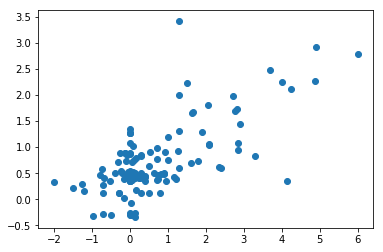

In [58]:
plt.scatter(x=y_test.values, y=y_pred_test)
#plt.xlim([1.5,4])
#plt.ylim([1.5,4])
#plt.plot([1.5,4],[1.5,4])
plt.show()

In [59]:
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = None, scoring = 'neg_mean_squared_error',n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,5)

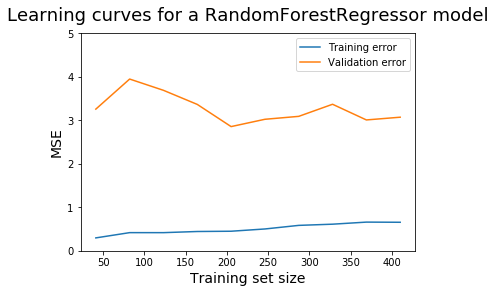

In [60]:
learning_curves(model,X,y,None)

In [47]:
np.linspace(.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

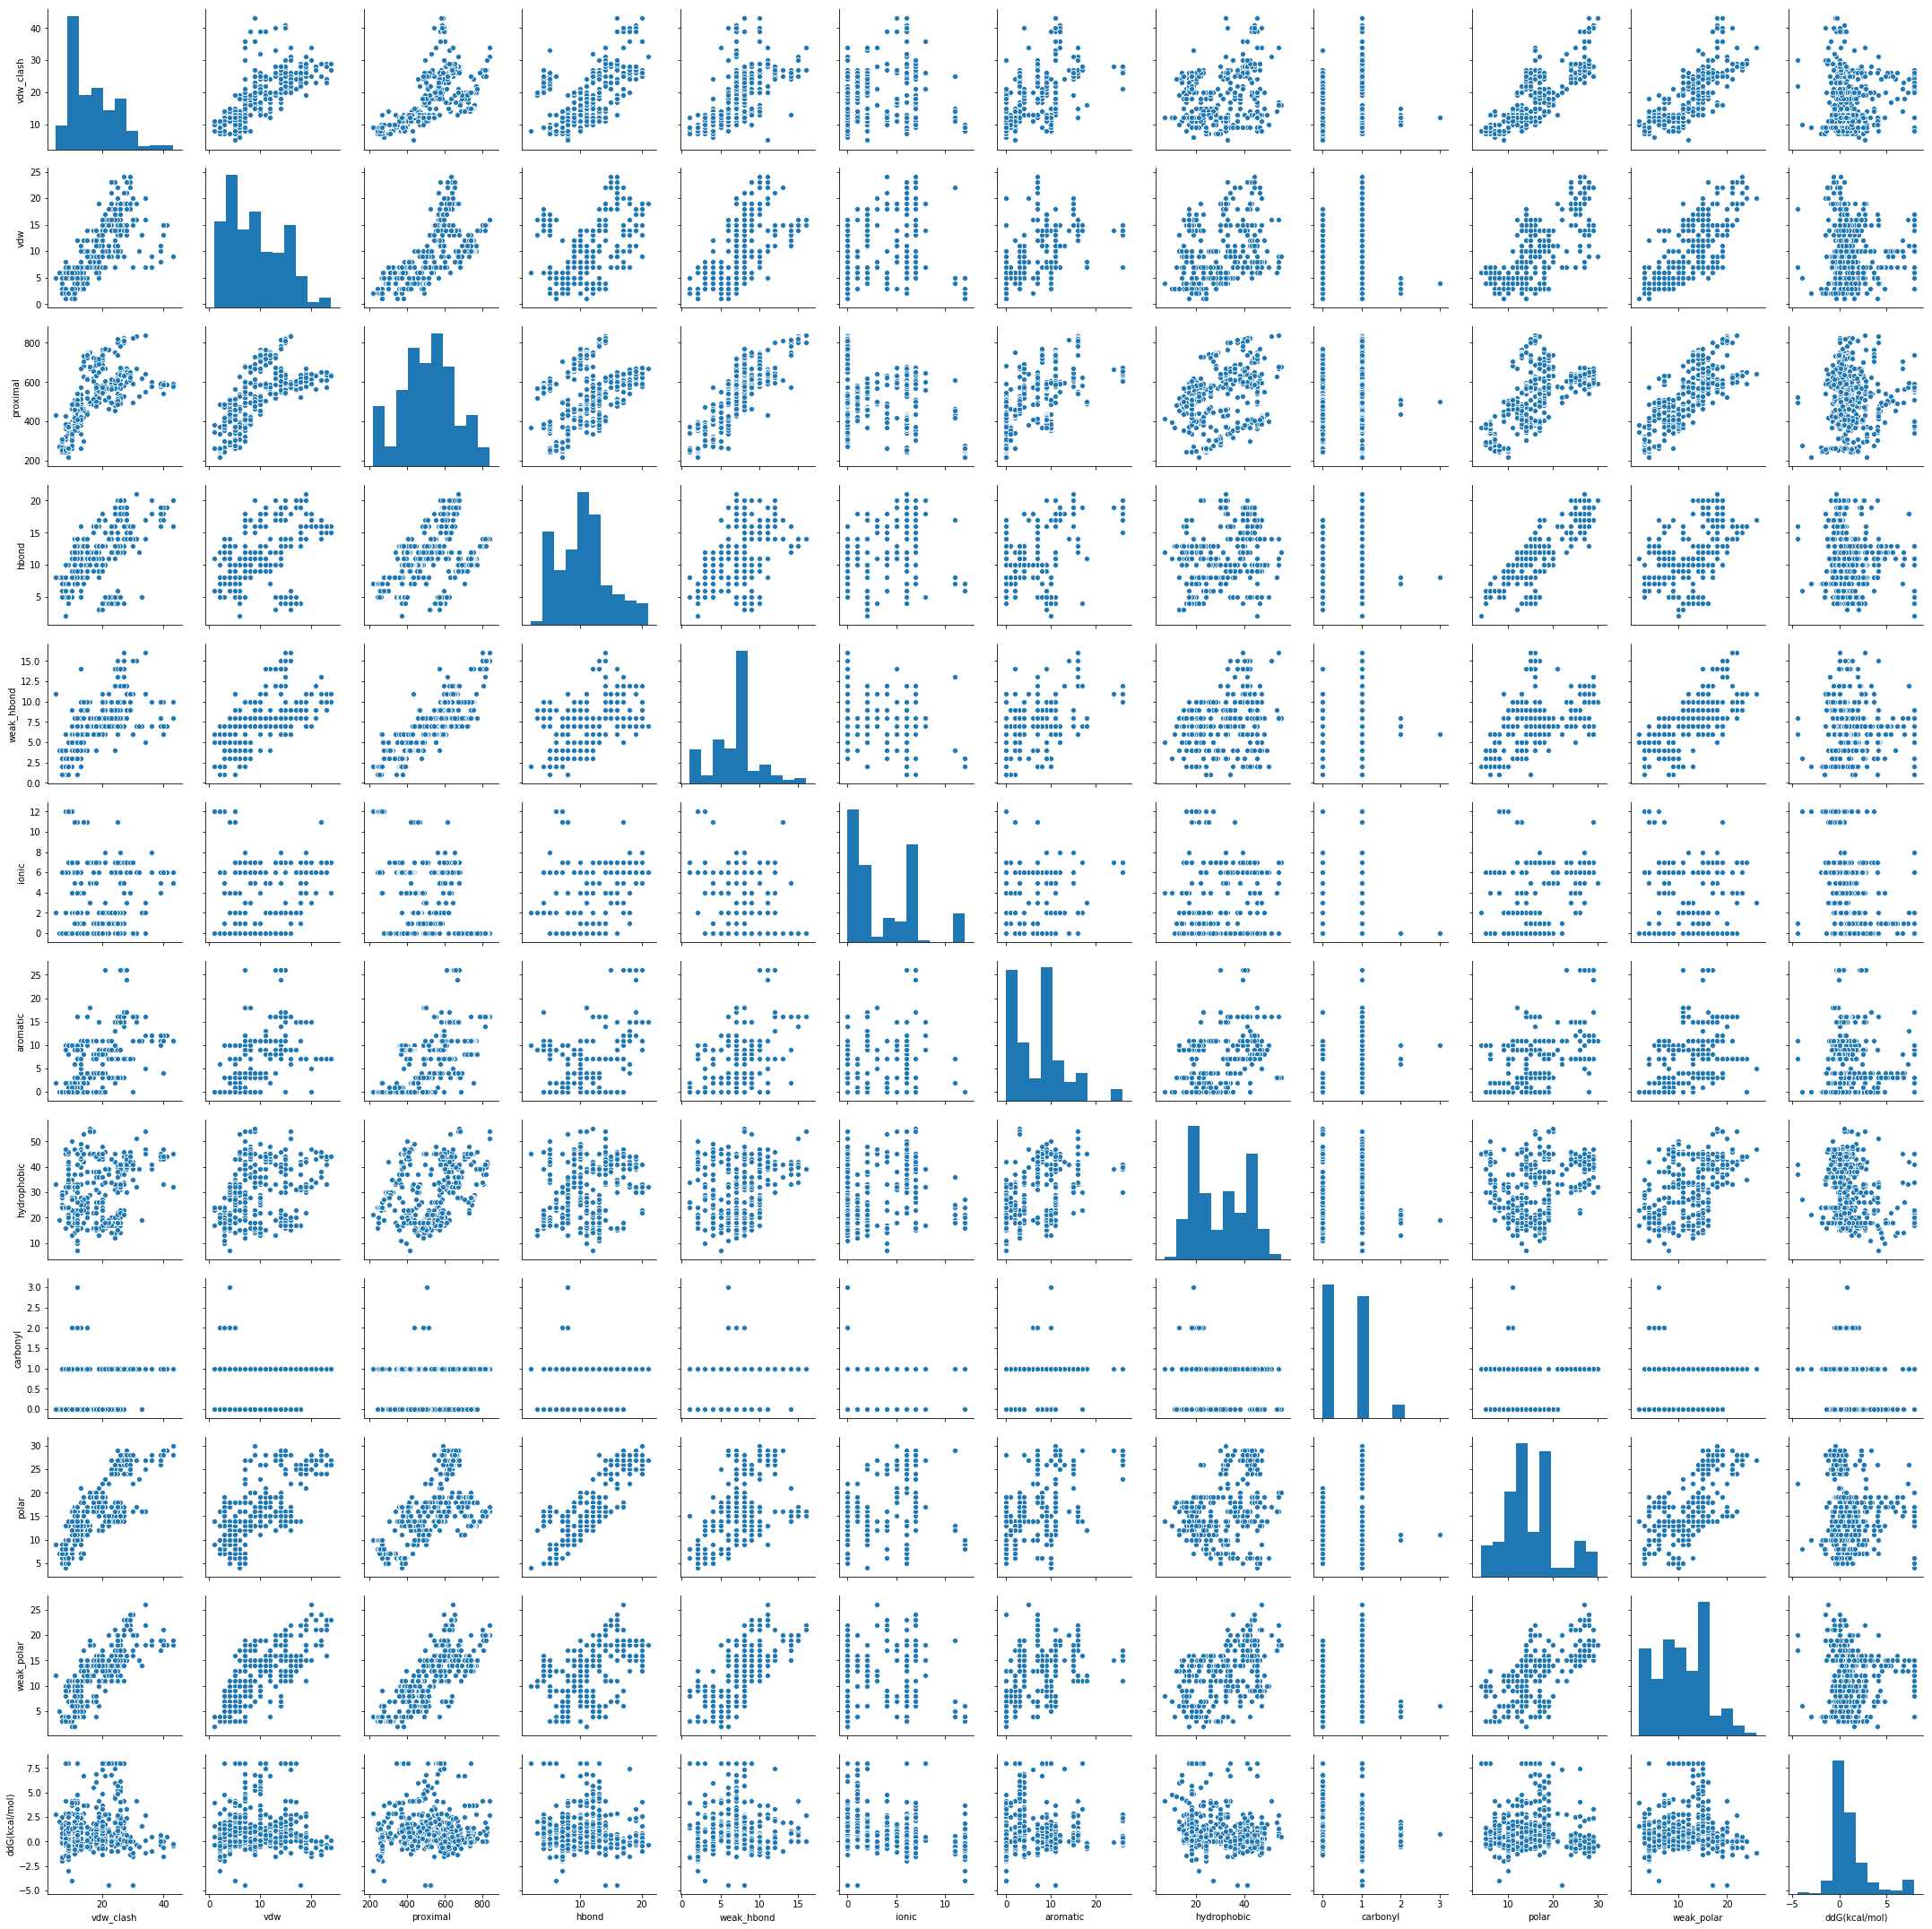

In [154]:
sns.pairplot(df_final_f1)